In [26]:
# 1) Setup & imports
# If needed (ArcGIS Pro ships with conda); uncomment to install in your current kernel.
# !pip install -q rasterio numpy tqdm

from pathlib import Path
import re
from collections import defaultdict
from tqdm import tqdm
import numpy as np
import rasterio
from rasterio.merge import merge as rio_merge
from rasterio.enums import Resampling

In [27]:
#2) Paths & user switches
# --- INPUTS ---
IN_DIR  = Path(r"C:\Users\ibana\Desktop\JRC_Tanganica\GIS_Intermediate\Intermediate_files\SurfaceWater\GEE_SW\indiv")
OUT_DIR = Path(r"C:\Users\ibana\Desktop\JRC_Tanganica\GIS_Intermediate\Intermediate_files\SurfaceWater\GEE_SW\mosaics")

# Create output folder if missing
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Expected coverage (for a quick completeness check)
EXPECTED_START = (2022, 1)   # YYYY, MM
EXPECTED_END   = (2025, 7)   # inclusive

# Processing switches
OVERWRITE          = False     # Set True to overwrite existing mosaics
BUILD_OVERVIEWS    = True      # Build internal pyramids for fast browsing
CHECK_CONSISTENCY  = True      # Validate CRS/res/dtype/nodata within each month
VERBOSE_DIAGNOSTICS = True     # Print a short per-month diagnostic before mosaicking


In [28]:
# 3) Discover & group input tiles by month
# Accept both .tif and .tiff (and even un-suffixed files if present)
candidates = list(IN_DIR.glob("SW_*"))  # broad match
# Keep only files (skip folders) and typical raster suffixes if present
files = [p for p in candidates if p.is_file() and (p.suffix.lower() in ('.tif', '.tiff', '') )]

# Regex to capture YYYY and MM from names like: SW_2022_01-0000000000-0000000000.tif
pat = re.compile(r"^SW_(\d{4})_(\d{2})-")

groups = defaultdict(list)
for p in files:
    stem = p.stem  # filename without extension
    m = pat.match(stem)
    if m:
        yyyy, mm = int(m.group(1)), int(m.group(2))
        key = f"{yyyy:04d}_{mm:02d}"
        groups[key].append(p)

# Sort paths within each month for reproducibility
for k in groups:
    groups[k] = sorted(groups[k])
    
print(f"Discovered {len(files)} tile files; grouped into {len(groups)} month(s).")
print("Example group keys (up to 10):", sorted(list(groups.keys()))[:10])

Discovered 172 tile files; grouped into 43 month(s).
Example group keys (up to 10): ['2022_01', '2022_02', '2022_03', '2022_04', '2022_05', '2022_06', '2022_07', '2022_08', '2022_09', '2022_10']


In [29]:
#4) Completeness check (optional but useful for QA)

def yyyymm_iter(start_y, start_m, end_y, end_m):
    y, m = start_y, start_m
    while (y, m) <= (end_y, end_m):
        yield f"{y:04d}_{m:02d}"
        # increment month
        if m == 12:
            y, m = y + 1, 1
        else:
            m += 1

expected_keys = set(yyyymm_iter(*EXPECTED_START, *EXPECTED_END))
present_keys  = set(groups.keys())
missing = sorted(expected_keys - present_keys)
extra   = sorted(present_keys - expected_keys)

print("Missing months (relative to expected window):", missing if missing else "None")
print("Unexpected months (outside expected window):", extra   if extra   else "None")


Missing months (relative to expected window): None
Unexpected months (outside expected window): None


In [30]:
# 5) Helper: consistency check within a month

def check_month_consistency(paths):
    """Ensure CRS, pixel size (affine), dtype, nodata match across all tiles."""
    with rasterio.open(paths[0]) as ref:
        ref_crs   = ref.crs
        ref_trans = ref.transform
        ref_res   = (ref.transform.a, -ref.transform.e)  # (xres, yres)
        ref_dtype = ref.dtypes[0]
        ref_nd    = ref.nodata
        ref_cnt   = ref.count  # band count

    for p in paths[1:]:
        with rasterio.open(p) as ds:
            if ds.crs != ref_crs:
                raise ValueError(f"CRS mismatch in {p.name}")
            if ds.dtypes[0] != ref_dtype:
                raise ValueError(f"dtype mismatch in {p.name}: {ds.dtypes[0]} != {ref_dtype}")
            if ds.count != ref_cnt:
                raise ValueError(f"Band-count mismatch in {p.name}: {ds.count} != {ref_cnt}")
            # check approximate resolution equality via transform
            res = (ds.transform.a, -ds.transform.e)
            if not (np.isclose(res[0], ref_res[0]) and np.isclose(res[1], ref_res[1])):
                raise ValueError(f"Resolution mismatch in {p.name}: {res} != {ref_res}")
            # nodata can be None in some files—warn but don’t fail
            if (ref_nd is not None) and (ds.nodata != ref_nd):
                print(f"[warn] nodata differs in {p.name}: {ds.nodata} vs ref {ref_nd}")
    return dict(crs=ref_crs, transform=ref_trans, res=ref_res, dtype=ref_dtype, nodata=ref_nd, count=ref_cnt)


In [31]:
# 6) Helper: mosaic a month and write GeoTIFF

def mosaic_month(paths, out_path, overwrite=False, build_ovr=True, diagnostics=True):
    if out_path.exists() and not overwrite:
        if diagnostics:
            print(f"[skip] {out_path.name} already exists.")
        return

    if CHECK_CONSISTENCY:
        meta_chk = check_month_consistency(paths)
    else:
        with rasterio.open(paths[0]) as ref:
            meta_chk = dict(crs=ref.crs, transform=ref.transform,
                            res=(ref.transform.a, -ref.transform.e),
                            dtype=ref.dtypes[0], nodata=ref.nodata, count=ref.count)

    if diagnostics:
        print(f"  tiles: {len(paths)} | crs: {meta_chk['crs']} | res: {meta_chk['res']} "
              f"| dtype: {meta_chk['dtype']} | bands: {meta_chk['count']} | nodata: {meta_chk['nodata']}")

    # Open all tiles as rasterio datasets
    srcs = [rasterio.open(p) for p in paths]
    try:
        # Merge; default method is 'first' (appropriate if tiles do not overlap).
        # If you suspect overlaps and want a "water wins" strategy, set method=np.maximum.
        mosaic, out_transform = rio_merge(
            srcs, nodata=meta_chk['nodata'], method='first'
            # method=np.maximum   # alternative if overlaps exist for binary masks
        )

    finally:
        for s in srcs:
            s.close()

    # Prepare output profile
    # Use first tile as template then update dimensions / transform
    with rasterio.open(paths[0]) as ref:
        profile = ref.profile.copy()

    profile.update({
        'height': mosaic.shape[1],
        'width' : mosaic.shape[2],
        'transform': out_transform,
        'compress': 'DEFLATE',
        'predictor': 2,            # good for integer data
        'tiled': True,
        'blockxsize': 512,
        'blockysize': 512,
        'BIGTIFF': 'IF_SAFER',
        'driver': 'GTiff',
        'nodata': meta_chk['nodata'],
        'dtype': meta_chk['dtype'],
        'count': mosaic.shape[0]
    })

    # Write GeoTIFF
    with rasterio.open(out_path, 'w', **profile) as dst:
        dst.write(mosaic)
        if build_ovr:
            # Internal overviews (pyramids) for snappy panning in GIS viewers
            factors = [2, 4, 8, 16, 32]
            dst.build_overviews(factors, Resampling.nearest)
            dst.update_tags(ns='rio_overview', resampling='nearest')


In [32]:
# 7) Run the mosaicking (with progress bars)

# Only process months we have on disk, in chronological order
month_keys = sorted(groups.keys())  # e.g. ['2022_01', '2022_02', ...]
print(f"Preparing to mosaic {len(month_keys)} months to\n  {OUT_DIR}")

for key in tqdm(month_keys, desc="Monthly mosaics", unit="month"):
    yyyy, mm = key.split("_")
    out_name = f"sw_{yyyy}_{mm}.tif"
    out_path = OUT_DIR / out_name
    paths = groups[key]
    if VERBOSE_DIAGNOSTICS:
        print(f"\nMosaicking {key} → {out_name}")
    mosaic_month(paths, out_path, overwrite=OVERWRITE,
                 build_ovr=BUILD_OVERVIEWS, diagnostics=VERBOSE_DIAGNOSTICS)


Preparing to mosaic 43 months to
  C:\Users\ibana\Desktop\JRC_Tanganica\GIS_Intermediate\Intermediate_files\SurfaceWater\GEE_SW\mosaics


Monthly mosaics:   0%|          | 0/43 [00:00<?, ?month/s]


Mosaicking 2022_01 → sw_2022_01.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:   2%|▏         | 1/43 [00:36<25:36, 36.59s/month]


Mosaicking 2022_02 → sw_2022_02.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:   5%|▍         | 2/43 [01:13<25:06, 36.75s/month]


Mosaicking 2022_03 → sw_2022_03.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:   7%|▋         | 3/43 [01:49<24:20, 36.51s/month]


Mosaicking 2022_04 → sw_2022_04.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:   9%|▉         | 4/43 [02:26<23:46, 36.57s/month]


Mosaicking 2022_05 → sw_2022_05.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  12%|█▏        | 5/43 [03:02<23:08, 36.55s/month]


Mosaicking 2022_06 → sw_2022_06.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  14%|█▍        | 6/43 [03:39<22:39, 36.75s/month]


Mosaicking 2022_07 → sw_2022_07.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  16%|█▋        | 7/43 [04:16<22:05, 36.81s/month]


Mosaicking 2022_08 → sw_2022_08.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  19%|█▊        | 8/43 [04:52<21:19, 36.57s/month]


Mosaicking 2022_09 → sw_2022_09.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  21%|██        | 9/43 [05:28<20:33, 36.28s/month]


Mosaicking 2022_10 → sw_2022_10.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  23%|██▎       | 10/43 [06:04<19:54, 36.21s/month]


Mosaicking 2022_11 → sw_2022_11.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  26%|██▌       | 11/43 [06:40<19:17, 36.16s/month]


Mosaicking 2022_12 → sw_2022_12.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  28%|██▊       | 12/43 [07:16<18:40, 36.13s/month]


Mosaicking 2023_01 → sw_2023_01.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  30%|███       | 13/43 [07:52<17:59, 36.00s/month]


Mosaicking 2023_02 → sw_2023_02.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  33%|███▎      | 14/43 [08:28<17:23, 35.97s/month]


Mosaicking 2023_03 → sw_2023_03.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  35%|███▍      | 15/43 [09:04<16:48, 36.02s/month]


Mosaicking 2023_04 → sw_2023_04.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  37%|███▋      | 16/43 [09:40<16:13, 36.04s/month]


Mosaicking 2023_05 → sw_2023_05.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  40%|███▉      | 17/43 [10:16<15:34, 35.95s/month]


Mosaicking 2023_06 → sw_2023_06.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  42%|████▏     | 18/43 [10:52<15:02, 36.11s/month]


Mosaicking 2023_07 → sw_2023_07.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  44%|████▍     | 19/43 [11:28<14:23, 35.96s/month]


Mosaicking 2023_08 → sw_2023_08.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  47%|████▋     | 20/43 [12:04<13:47, 35.96s/month]


Mosaicking 2023_09 → sw_2023_09.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  49%|████▉     | 21/43 [12:40<13:14, 36.12s/month]


Mosaicking 2023_10 → sw_2023_10.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  51%|█████     | 22/43 [13:17<12:39, 36.15s/month]


Mosaicking 2023_11 → sw_2023_11.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  53%|█████▎    | 23/43 [13:53<12:02, 36.12s/month]


Mosaicking 2023_12 → sw_2023_12.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  56%|█████▌    | 24/43 [14:28<11:23, 35.96s/month]


Mosaicking 2024_01 → sw_2024_01.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  58%|█████▊    | 25/43 [15:04<10:45, 35.86s/month]


Mosaicking 2024_02 → sw_2024_02.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  60%|██████    | 26/43 [15:40<10:09, 35.85s/month]


Mosaicking 2024_03 → sw_2024_03.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  63%|██████▎   | 27/43 [16:16<09:33, 35.86s/month]


Mosaicking 2024_04 → sw_2024_04.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  65%|██████▌   | 28/43 [16:51<08:57, 35.83s/month]


Mosaicking 2024_05 → sw_2024_05.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  67%|██████▋   | 29/43 [17:29<08:27, 36.28s/month]


Mosaicking 2024_06 → sw_2024_06.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  70%|██████▉   | 30/43 [18:05<07:52, 36.32s/month]


Mosaicking 2024_07 → sw_2024_07.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  72%|███████▏  | 31/43 [18:41<07:15, 36.33s/month]


Mosaicking 2024_08 → sw_2024_08.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  74%|███████▍  | 32/43 [19:18<06:38, 36.25s/month]


Mosaicking 2024_09 → sw_2024_09.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  77%|███████▋  | 33/43 [19:53<06:00, 36.02s/month]


Mosaicking 2024_10 → sw_2024_10.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  79%|███████▉  | 34/43 [20:29<05:23, 35.96s/month]


Mosaicking 2024_11 → sw_2024_11.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  81%|████████▏ | 35/43 [21:05<04:47, 35.89s/month]


Mosaicking 2024_12 → sw_2024_12.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  84%|████████▎ | 36/43 [21:41<04:12, 36.14s/month]


Mosaicking 2025_01 → sw_2025_01.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  86%|████████▌ | 37/43 [22:18<03:37, 36.27s/month]


Mosaicking 2025_02 → sw_2025_02.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  88%|████████▊ | 38/43 [22:54<03:01, 36.36s/month]


Mosaicking 2025_03 → sw_2025_03.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  91%|█████████ | 39/43 [23:30<02:25, 36.27s/month]


Mosaicking 2025_04 → sw_2025_04.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  93%|█████████▎| 40/43 [24:06<01:48, 36.08s/month]


Mosaicking 2025_05 → sw_2025_05.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  95%|█████████▌| 41/43 [24:42<01:11, 35.94s/month]


Mosaicking 2025_06 → sw_2025_06.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics:  98%|█████████▊| 42/43 [25:17<00:35, 35.82s/month]


Mosaicking 2025_07 → sw_2025_07.tif
  tiles: 4 | crs: EPSG:4326 | res: (8.983152841195215e-05, 8.983152841195215e-05) | dtype: uint8 | bands: 1 | nodata: None


Monthly mosaics: 100%|██████████| 43/43 [25:53<00:00, 36.12s/month]﻿


In [33]:
# 8) Lightweight diagnostics summary

# How many tiles fed each month? Any single-tile months?
summary = [(k, len(v)) for k, v in sorted(groups.items())]
print("\nPer-month tile counts (first 20):")
for k, n in summary[:20]:
    print(f"  {k}: {n} tiles")
print(f"... total months: {len(summary)}")



Per-month tile counts (first 20):
  2022_01: 4 tiles
  2022_02: 4 tiles
  2022_03: 4 tiles
  2022_04: 4 tiles
  2022_05: 4 tiles
  2022_06: 4 tiles
  2022_07: 4 tiles
  2022_08: 4 tiles
  2022_09: 4 tiles
  2022_10: 4 tiles
  2022_11: 4 tiles
  2022_12: 4 tiles
  2023_01: 4 tiles
  2023_02: 4 tiles
  2023_03: 4 tiles
  2023_04: 4 tiles
  2023_05: 4 tiles
  2023_06: 4 tiles
  2023_07: 4 tiles
  2023_08: 4 tiles
... total months: 43


In [34]:
# 9) Analysis folder, dependencies, and mosaic manifest

# If needed:
# !pip install -q pandas rasterio numpy tqdm

from pathlib import Path
import re
import math
import pandas as pd
import numpy as np
import rasterio
from rasterio.windows import Window
from tqdm import tqdm

# --- ANALYSIS OUTPUT DIR ---
ANALYSIS_DIR = Path(r"C:\Users\ibana\Desktop\JRC_Tanganica\GIS_Intermediate\Intermediate_files\SurfaceWater\GEE_SW") / "Analysis"
ANALYSIS_DIR.mkdir(parents=True, exist_ok=True)

# Scan mosaics written in block #7 (sw_YYYY_MM.tif)
mosaic_paths = sorted(OUT_DIR.glob("sw_????_??.tif"))

def parse_yyyymm(p: Path):
    m = re.search(r"sw_(\d{4})_(\d{2})\.tif$", p.name)
    if not m:
        return None, None
    return int(m.group(1)), int(m.group(2))

manifest_rows = []
for p in mosaic_paths:
    y, m = parse_yyyymm(p)
    if y is None:
        continue
    with rasterio.open(p) as ds:
        left, bottom, right, top = ds.bounds
        transform = ds.transform
        row = {
            "file": str(p),
            "year": y,
            "month": m,
            "crs": str(ds.crs),
            "width": ds.width,
            "height": ds.height,
            "bands": ds.count,
            "dtype": ds.dtypes[0],
            "nodata": ds.nodata,
            "pixel_deg_x": transform.a,
            "pixel_deg_y": abs(transform.e),
            "left": left, "right": right, "top": top, "bottom": bottom,
            "filesize_bytes": p.stat().st_size
        }
        manifest_rows.append(row)

manifest_df = pd.DataFrame(manifest_rows).sort_values(["year","month"]).reset_index(drop=True)
manifest_csv = ANALYSIS_DIR / "mosaic_manifest.csv"
manifest_df.to_csv(manifest_csv, index=False, encoding="utf-8-sig")
manifest_df.head(10)


,file,year,month,crs,width,height,bands,dtype,nodata,pixel_deg_x,pixel_deg_y,left,right,top,bottom,filesize_bytes
0,C:\Users\ibana\Desktop\JRC_Tanganica\GIS_Inter...,2022,1,OGC:CRS84,79046,92456,1,uint8,None,0.00009,0.00009,26.91649,34.017313,-1.395084,-9.700547,10911943
1,C:\Users\ibana\Desktop\JRC_Tanganica\GIS_Inter...,2022,2,OGC:CRS84,79046,92456,1,uint8,None,0.00009,0.00009,26.91649,34.017313,-1.395084,-9.700547,11135005
2,C:\Users\ibana\Desktop\JRC_Tanganica\GIS_Inter...,2022,3,OGC:CRS84,79046,92456,1,uint8,None,0.00009,0.00009,26.91649,34.017313,-1.395084,-9.700547,11157769
3,C:\Users\ibana\Desktop\JRC_Tanganica\GIS_Inter...,2022,4,OGC:CRS84,79046,92456,1,uint8,None,0.00009,0.00009,26.91649,34.017313,-1.395084,-9.700547,11132309
4,C:\Users\ibana\Desktop\JRC_Tanganica\GIS_Inter...,2022,5,OGC:CRS84,79046,92456,1,uint8,None,0.00009,0.00009,26.91649,34.017313,-1.395084,-9.700547,11078377
5,C:\Users\ibana\Desktop\JRC_Tanganica\GIS_Inter...,2022,6,OGC:CRS84,79046,92456,1,uint8,None,0.00009,0.00009,26.91649,34.017313,-1.395084,-9.700547,10839635
6,C:\Users\ibana\Desktop\JRC_Tanganica\GIS_Inter...,2022,7,OGC:CRS84,79046,92456,1,uint8,None,0.00009,0.00009,26.91649,34.017313,-1.395084,-9.700547,10835945
7,C:\Users\ibana\Desktop\JRC_Tanganica\GIS_Inter...,2022,8,OGC:CRS84,79046,92456,1,uint8,None,0.00009,0.00009,26.91649,34.017313,-1.395084,-9.700547,10787147
8,C:\Users\ibana\Desktop\JRC_Tanganica\GIS_Inter...,2022,9,OGC:CRS84,79046,92456,1,uint8,None,0.00009,0.00009,26.91649,34.017313,-1.395084,-9.700547,10779031
9,C:\Users\ibana\Desktop\JRC_Tanganica\GIS_Inter...,2022,10,OGC:CRS84,79046,92456,1,uint8,None,0.00009,0.00009,26.91649,34.017313,-1.395084,-9.700547,10728025


In [35]:
# 10) Row-wise geodesic area (WGS84) and pixel counts per mosaic

R_EARTH = 6378137.0  # meters (WGS84)
D2R = math.pi / 180.0

def row_pixel_area_km2(lat_top_deg, lat_bottom_deg, pixel_deg_x):
    """Spherical area (km²) of one pixel column in a given row (bounded by lat_top/bottom)."""
    lat1 = min(lat_top_deg, lat_bottom_deg) * D2R
    lat2 = max(lat_top_deg, lat_bottom_deg) * D2R
    dlon = abs(pixel_deg_x) * D2R
    area_m2 = (R_EARTH**2) * dlon * (math.sin(lat2) - math.sin(lat1))
    return area_m2 / 1e6  # km²

def water_stats_geodesic(mosaic_path, show_row_progress=False):
    """Compute valid pixel count, water pixel count, and geodesic areas for a single-band mask."""
    with rasterio.open(mosaic_path) as ds:
        assert ds.count >= 1, "Expected at least one band."
        transform = ds.transform
        height, width = ds.height, ds.width
        nodata = ds.nodata

        # Precompute latitude edges for each row
        # Row r top edge latitude (northing in degrees) = transform.f + r * transform.e
        # Bottom edge = transform.f + (r+1) * transform.e
        lat_edges_top = transform.f + np.arange(0, height) * transform.e
        lat_edges_bot = transform.f + np.arange(1, height+1) * transform.e
        # Pixel width in degrees (constant)
        px_deg_x = transform.a

        valid_px_total = 0
        water_px_total = 0
        valid_km2_total = 0.0
        water_km2_total = 0.0

        row_iter = range(height)
        if show_row_progress:
            row_iter = tqdm(row_iter, desc=f"Rows {mosaic_path.name}", unit="row", leave=False)

        for r in row_iter:
            # Read one row as a masked array (nodata respected)
            arr = ds.read(1, window=Window(0, r, width, 1), masked=True).squeeze()  # shape (width,)
            # Valid = not masked
            valid_mask = ~arr.mask
            # Water = valid & non-zero (robust across bool/int)
            water_mask = valid_mask & (arr.filled(0) != 0)

            # Per-row pixel area (km²)
            a_row = row_pixel_area_km2(lat_edges_top[r], lat_edges_bot[r], px_deg_x)

            v_count = int(valid_mask.sum())
            w_count = int(water_mask.sum())

            valid_px_total += v_count
            water_px_total += w_count

            valid_km2_total += v_count * a_row
            water_km2_total += w_count * a_row

        return {
            "valid_px": valid_px_total,
            "water_px": water_px_total,
            "valid_km2": valid_km2_total,
            "water_km2": water_km2_total
        }


In [36]:
# 11) Compute stats for all mosaics and export tidy CSVs

stats_rows = []
for p in tqdm(mosaic_paths, desc="Area & pixel stats", unit="mosaic"):
    y, m = parse_yyyymm(p)
    s = water_stats_geodesic(p, show_row_progress=False)  # set True if you want nested row bars
    row = {
        "file": str(p),
        "year": y,
        "month": m,
        "valid_px": s["valid_px"],
        "water_px": s["water_px"],
        "valid_km2": round(s["valid_km2"], 5),
        "water_km2": round(s["water_km2"], 5),
    }
    # percentages (guard against division by zero)
    row["water_pct_of_valid_px"] = (100.0 * row["water_px"] / row["valid_px"]) if row["valid_px"] else np.nan
    row["water_pct_of_valid_km2"] = (100.0 * row["water_km2"] / row["valid_km2"]) if row["valid_km2"] else np.nan
    stats_rows.append(row)

stats_df = pd.DataFrame(stats_rows).sort_values(["year","month"]).reset_index(drop=True)
stats_csv = ANALYSIS_DIR / "mosaic_water_area_stats.csv"
stats_df.to_csv(stats_csv, index=False, encoding="utf-8-sig")
stats_df.head(12)


Area & pixel stats: 100%|██████████| 43/43 [22:18<00:00, 31.13s/mosaic]﻿


,file,year,month,valid_px,water_px,valid_km2,water_km2,water_pct_of_valid_px,water_pct_of_valid_km2
0,C:\Users\ibana\Desktop\JRC_Tanganica\GIS_Inter...,2022,1,92456,361926515,9.19424,35983.27548,391458.115212,391367.589708
1,C:\Users\ibana\Desktop\JRC_Tanganica\GIS_Inter...,2022,2,92456,362740225,9.19424,36064.22876,392338.220343,392248.067921
2,C:\Users\ibana\Desktop\JRC_Tanganica\GIS_Inter...,2022,3,92456,363030677,9.19424,36093.13595,392652.371939,392562.473353
3,C:\Users\ibana\Desktop\JRC_Tanganica\GIS_Inter...,2022,4,92456,362915436,9.19424,36081.64861,392527.727784,392437.532738
4,C:\Users\ibana\Desktop\JRC_Tanganica\GIS_Inter...,2022,5,92456,362786207,9.19424,36068.84112,392387.954270,392298.233677
5,C:\Users\ibana\Desktop\JRC_Tanganica\GIS_Inter...,2022,6,92456,362539734,9.19424,36044.25832,392121.370165,392030.861931
6,C:\Users\ibana\Desktop\JRC_Tanganica\GIS_Inter...,2022,7,92456,362492134,9.19424,36039.52890,392069.886216,391979.422987
7,C:\Users\ibana\Desktop\JRC_Tanganica\GIS_Inter...,2022,8,92456,362355723,9.19424,36025.94719,391922.344683,391831.703219
8,C:\Users\ibana\Desktop\JRC_Tanganica\GIS_Inter...,2022,9,92456,362255521,9.19424,36015.96275,391813.966644,391723.108707
9,C:\Users\ibana\Desktop\JRC_Tanganica\GIS_Inter...,2022,10,92456,362029252,9.19424,35993.45426,391569.235096,391478.297934


In [38]:
# 12) (Optional) Merge manifest + stats and sanity checks

merged_df = (manifest_df
             .merge(stats_df, on=["file","year","month"], how="left")
             .sort_values(["year","month"])
             .reset_index(drop=True))

merged_csv = ANALYSIS_DIR / "mosaic_manifest_plus_stats.csv"
merged_df.to_csv(merged_csv, index=False, encoding="utf-8-sig")

# Quick sanity prints
print("Temporal coverage (first 8 rows):")
display(merged_df[["year","month","width","height","water_km2","water_pct_of_valid_km2"]].head(8))

print("\nMissing months with no stats?")
miss_stats = merged_df[merged_df["water_km2"].isna()][["year","month","file"]]
display(miss_stats if not miss_stats.empty else "None")


Temporal coverage (first 8 rows):


,year,month,width,height,water_km2,water_pct_of_valid_km2
0,2022,1,79046,92456,35983.27548,391367.589708
1,2022,2,79046,92456,36064.22876,392248.067921
2,2022,3,79046,92456,36093.13595,392562.473353
3,2022,4,79046,92456,36081.64861,392437.532738
4,2022,5,79046,92456,36068.84112,392298.233677
5,2022,6,79046,92456,36044.25832,392030.861931
6,2022,7,79046,92456,36039.52890,391979.422987
7,2022,8,79046,92456,36025.94719,391831.703219



Missing months with no stats?


'None'

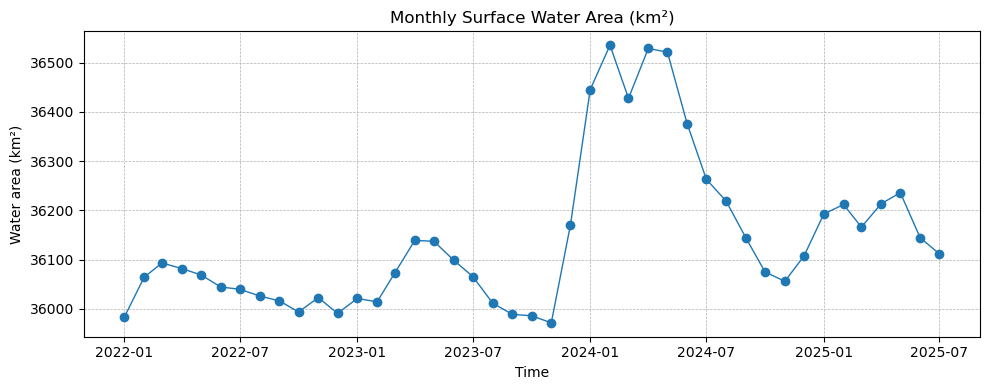

In [39]:
# 13) (Optional) Quick-look time series plot (portable Matplotlib)

# !pip install -q matplotlib
import matplotlib.pyplot as plt
ts = merged_df[["year","month","water_km2"]].dropna().copy()
ts["yyyymm"] = pd.to_datetime(ts["year"].astype(str) + "-" + ts["month"].astype(str) + "-01")

plt.figure(figsize=(10,4))
plt.plot(ts["yyyymm"], ts["water_km2"], marker="o", linewidth=1)
plt.title("Monthly Surface Water Area (km²)")
plt.xlabel("Time")
plt.ylabel("Water area (km²)")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
